In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

In [3]:
cur_folder_name = os.getcwd().split('/')[-1]
if cur_folder_name != "fairness-variance":
    os.chdir("../..")

print('Current location: ', os.getcwd())

Current location:  /Users/denys_herasymuk/UCU/4course_2term/Bachelor_Thesis/Code/fairness-variance


# Visualizations

In [4]:
from source.utils.data_vis_utils import unpivot_group_metrics
from source.uncertainty_visualizations import create_plot_for_diff_bootstrap_sizes

pip install 'aif360[LawSchoolGPA]'


## Initialize Configs

In [5]:
DB_COLLECTION_NAME = 'one_repair_lvl_many_models'
DATASETS_DB_CONFIG = {
    'Folktables_GA_2018_Income': {
        'Bootstrap': 'ac796b56-9c83-474a-8e7a-2d95ee5efa7e',
        'Meta_Learner': '8c9cf23a-9b8f-49fd-a7e2-270c2c3db69c',
    },
    # 'Law_School': {
    #     'Bootstrap': 'b37c9c58-ed69-425c-b3d5-8f1ffd3adcd6',
    #     'Meta_Learner': '9c3f16a8-fc31-4bb1-b6a8-c535326d57d4',
    # },
}
DATASET_NAMES = list(DATASETS_DB_CONFIG.keys())
MODEL_NAMES = ['LR', 'RF']
SENSITIVE_ATTR_FOR_INTERVENTION = 'male&race'
DATASETS_SENSITIVE_ATTRS = {
    'Folktables_GA_2018_Income': ['SEX', 'RAC1P', 'SEX&RAC1P'],
    'Law_School': ['male', 'race', 'male&race'],
}

## Group Metrics Composition

In [6]:
import pandas as pd

from source.utils.db_functions import connect_to_mongodb
from source.utils.db_functions import read_model_metric_dfs_from_db
from virny.utils.custom_initializers import create_models_metrics_dct_from_database_df
from virny.custom_classes.metrics_composer import MetricsComposer


def read_metrics_for_meta_learner_testing(datasets_db_config: dict, datasets_sensitive_attrs_dct: dict, db_collection_name: str):
    client, collection_obj, db_writer_func = connect_to_mongodb(db_collection_name)
    all_subgroup_metrics_df = pd.DataFrame()
    all_group_metrics_df = pd.DataFrame()
    for dataset_name in datasets_db_config.keys():
        for uq_approach in datasets_db_config[dataset_name].keys():
            # Extract experimental data for the defined dataset from MongoDB
            model_metric_df = read_model_metric_dfs_from_db(collection_obj, datasets_db_config[dataset_name][uq_approach])
            model_metric_df = model_metric_df.drop(columns=['Model_Params', 'Tag', 'Model_Init_Seed'])
            model_metric_df['Approach'] = uq_approach
            all_subgroup_metrics_df = pd.concat([all_subgroup_metrics_df, model_metric_df])

            # Compose disparity metrics for the defined dataset
            cur_sensitive_attrs_dct = {attr: None for attr in datasets_sensitive_attrs_dct[dataset_name]}
            for exp_iter in model_metric_df['Experiment_Iteration'].unique():
                exp_iter_model_metric_df = model_metric_df[model_metric_df.Experiment_Iteration == exp_iter]
                models_metrics_dct = create_models_metrics_dct_from_database_df(exp_iter_model_metric_df)
                metrics_composer = MetricsComposer(models_metrics_dct, cur_sensitive_attrs_dct)
                model_composed_metrics_df = metrics_composer.compose_metrics()
                model_composed_metrics_df['Dataset_Name'] = dataset_name
                model_composed_metrics_df['Approach'] = uq_approach
                model_composed_metrics_df['Experiment_Iteration'] = exp_iter

                # Unpivot group columns to align with visualizations API
                unpivot_composed_metrics_df = unpivot_group_metrics(model_composed_metrics_df,
                                                                    datasets_sensitive_attrs_dct[dataset_name])
                all_group_metrics_df = pd.concat([all_group_metrics_df, unpivot_composed_metrics_df])

            print(f'Extracted metrics for {dataset_name} dataset and {uq_approach} approach')

    client.close()
    all_subgroup_metrics_df = all_subgroup_metrics_df.reset_index(drop=True)
    all_group_metrics_df = all_group_metrics_df.reset_index(drop=True)

    return all_subgroup_metrics_df, all_group_metrics_df

In [7]:
all_subgroup_metrics_df, all_group_metrics_df = (
    read_metrics_for_meta_learner_testing(datasets_db_config=DATASETS_DB_CONFIG,
                                          datasets_sensitive_attrs_dct=DATASETS_SENSITIVE_ATTRS,
                                          db_collection_name=DB_COLLECTION_NAME))

Extracted metrics for Law_School dataset and Bootstrap approach
Extracted metrics for Law_School dataset and Meta_Learner approach


In [8]:
all_subgroup_metrics_df.head(20)

,Metric,Model_Name,Dataset_Name,Num_Estimators,Record_Create_Date_Time,Session_Uuid,Experiment_Iteration,Dataset_Split_Seed,Fair_Intervention_Params_Lst,Intervention_Param,Subgroup,Metric_Value,Approach,Run_Start_Date_Time
0,IQR,LGBMClassifier,Law_School,200,2024-01-06 18:35:39.912,b37c9c58-ed69-425c-b3d5-8f1ffd3adcd6,Exp_iter_1,100,[0.0],0.0,male_priv,0.041784,Bootstrap,NaT
1,Overall_Uncertainty,LGBMClassifier,Law_School,200,2024-01-06 18:35:39.912,b37c9c58-ed69-425c-b3d5-8f1ffd3adcd6,Exp_iter_1,100,[0.0],0.0,male_priv,0.324259,Bootstrap,NaT
2,Mean_Prediction,LGBMClassifier,Law_School,200,2024-01-06 18:35:39.912,b37c9c58-ed69-425c-b3d5-8f1ffd3adcd6,Exp_iter_1,100,[0.0],0.0,male_priv,0.104920,Bootstrap,NaT
3,Aleatoric_Uncertainty,LGBMClassifier,Law_School,200,2024-01-06 18:35:39.912,b37c9c58-ed69-425c-b3d5-8f1ffd3adcd6,Exp_iter_1,100,[0.0],0.0,male_priv,0.312090,Bootstrap,NaT
4,Epistemic_Uncertainty,LGBMClassifier,Law_School,200,2024-01-06 18:35:39.912,b37c9c58-ed69-425c-b3d5-8f1ffd3adcd6,Exp_iter_1,100,[0.0],0.0,male_priv,0.012169,Bootstrap,NaT
5,TPR,LGBMClassifier,Law_School,200,2024-01-06 18:35:39.912,b37c9c58-ed69-425c-b3d5-8f1ffd3adcd6,Exp_iter_1,100,[0.0],0.0,male_priv,0.981352,Bootstrap,NaT
6,TNR,LGBMClassifier,Law_School,200,2024-01-06 18:35:39.912,b37c9c58-ed69-425c-b3d5-8f1ffd3adcd6,Exp_iter_1,100,[0.0],0.0,male_priv,0.228296,Bootstrap,NaT
7,Accuracy,LGBMClassifier,Law_School,200,2024-01-06 18:35:39.912,b37c9c58-ed69-425c-b3d5-8f1ffd3adcd6,Exp_iter_1,100,[0.0],0.0,male_priv,0.900173,Bootstrap,NaT
8,Selection-Rate,LGBMClassifier,Law_School,200,2024-01-06 18:35:39.912,b37c9c58-ed69-425c-b3d5-8f1ffd3adcd6,Exp_iter_1,100,[0.0],0.0,male_priv,0.958752,Bootstrap,NaT
9,Positive-Rate,LGBMClassifier,Law_School,200,2024-01-06 18:35:39.912,b37c9c58-ed69-425c-b3d5-8f1ffd3adcd6,Exp_iter_1,100,[0.0],0.0,male_priv,1.074592,Bootstrap,NaT


In [9]:
all_group_metrics_df.head(20)

,Metric,Model_Name,Dataset_Name,Approach,Experiment_Iteration,Group,Metric_Value
0,Accuracy_Difference,LGBMClassifier,Law_School,Bootstrap,Exp_iter_1,male,-0.008597
1,Aleatoric_Uncertainty_Difference,LGBMClassifier,Law_School,Bootstrap,Exp_iter_1,male,0.003942
2,Aleatoric_Uncertainty_Ratio,LGBMClassifier,Law_School,Bootstrap,Exp_iter_1,male,1.012629
3,Epistemic_Uncertainty_Difference,LGBMClassifier,Law_School,Bootstrap,Exp_iter_1,male,-0.000217
4,Epistemic_Uncertainty_Ratio,LGBMClassifier,Law_School,Bootstrap,Exp_iter_1,male,0.982147
5,Equalized_Odds_FNR,LGBMClassifier,Law_School,Bootstrap,Exp_iter_1,male,0.003027
6,Equalized_Odds_FPR,LGBMClassifier,Law_School,Bootstrap,Exp_iter_1,male,-0.045388
7,IQR_Difference,LGBMClassifier,Law_School,Bootstrap,Exp_iter_1,male,0.000353
8,Jitter_Difference,LGBMClassifier,Law_School,Bootstrap,Exp_iter_1,male,0.004323
9,Label_Stability_Ratio,LGBMClassifier,Law_School,Bootstrap,Exp_iter_1,male,0.992574


## Metrics Visualization and Reporting

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from altair.utils.schemapi import Undefined


def create_plot_for_overall_metrics(all_models_metrics_df: pd.DataFrame, dataset_name: str, metric_names: list,
                                    model_names: list, group: str = 'overall', ylim: tuple = None, vals_to_replace: dict = None):
    if vals_to_replace is not None:
        all_models_metrics_df = all_models_metrics_df.replace(vals_to_replace)

    group_col_name = 'Subgroup' if group == 'overall' else 'Group'
    to_plot = all_models_metrics_df[
        (all_models_metrics_df['Dataset_Name'] == dataset_name) &
        (all_models_metrics_df['Model_Name'].isin(model_names)) &
        (all_models_metrics_df['Metric'].isin(metric_names)) &
        (all_models_metrics_df[group_col_name] == group)
        ]

    plt.figure(figsize=(12, 6))
    g = sns.catplot(kind = "box",
                    data=to_plot,
                    x='Model_Name',
                    y='Metric_Value',
                    hue='Approach',
                    col='Metric',
                    col_order=metric_names,
                    legend=False)
    # Extra configs for the FacetGrid
    font_increase = 4 if len(metric_names) >= 3 else 6
    g.set_xlabels("")
    g.set_ylabels("Metric Value", fontsize=16 + font_increase)
    g.set_titles(size=14 + font_increase)
    g.tick_params(labelsize=14 + font_increase)
    g.set(ylim=ylim)
    g.despine(left=True)
    g.add_legend(title='Approach',
                 ncol=1,
                 fancybox=True,
                 shadow=True,
                 fontsize=13 + font_increase)
    plt.setp(g._legend.get_title(), fontsize=14 + font_increase)

### Group Metrics

In [11]:
vals_to_replace = {
    'Model_Name': {
        'LGBMClassifier': 'LGBM',
        'LogisticRegression': 'LR',
        'RandomForestClassifier': 'RF',
        'MLPClassifier': 'MLP'
    }
}

<Figure size 1200x600 with 0 Axes>

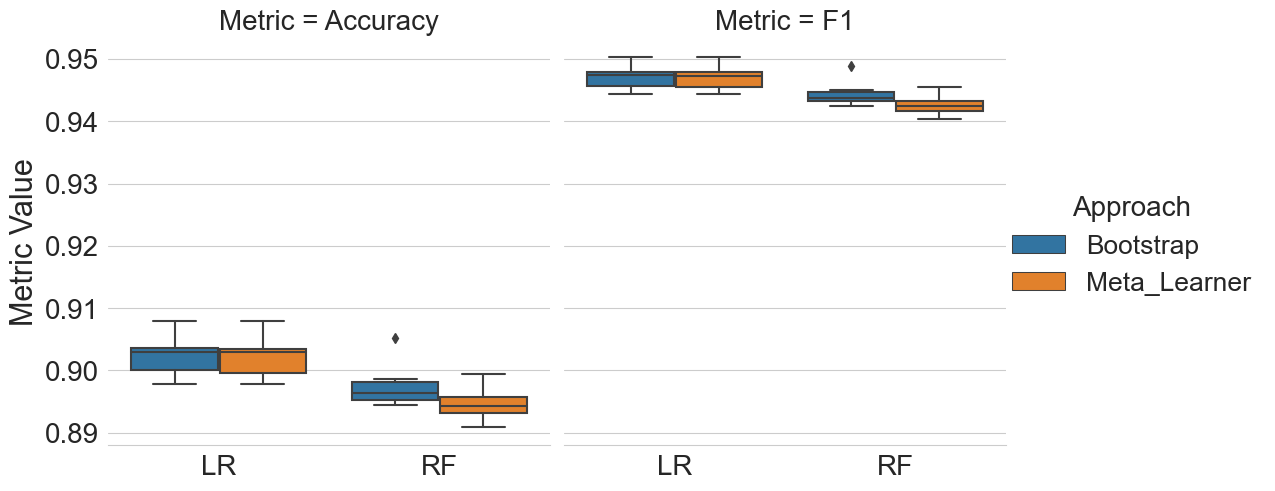

In [12]:
create_plot_for_overall_metrics(all_subgroup_metrics_df,
                                dataset_name=DATASET_NAMES[0],
                                model_names=MODEL_NAMES,
                                metric_names=['Accuracy', 'F1'],
                                vals_to_replace=vals_to_replace)

<Figure size 1200x600 with 0 Axes>

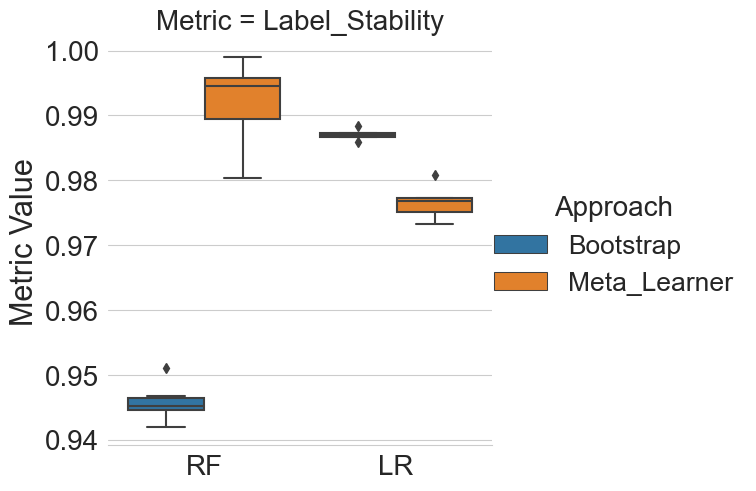

In [13]:
create_plot_for_overall_metrics(all_subgroup_metrics_df,
                                dataset_name=DATASET_NAMES[0],
                                model_names=MODEL_NAMES,
                                metric_names=['Label_Stability'],
                                vals_to_replace=vals_to_replace)

<Figure size 1200x600 with 0 Axes>

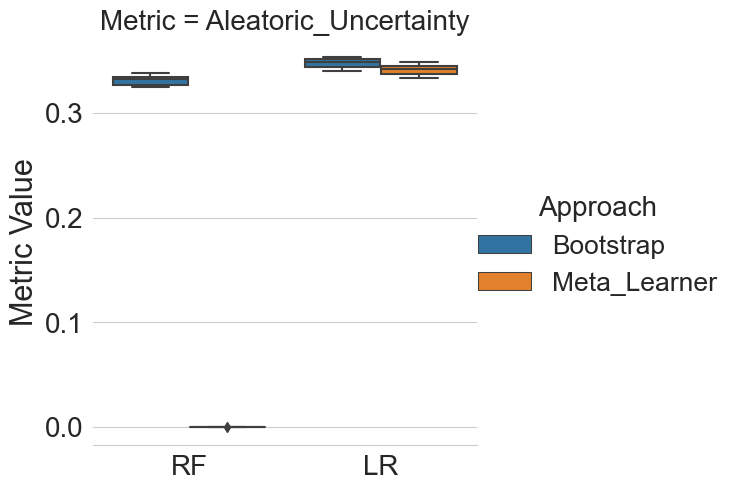

In [14]:
create_plot_for_overall_metrics(all_subgroup_metrics_df,
                                dataset_name=DATASET_NAMES[0],
                                model_names=MODEL_NAMES,
                                metric_names=['Aleatoric_Uncertainty'],
                                vals_to_replace=vals_to_replace)

<Figure size 1200x600 with 0 Axes>

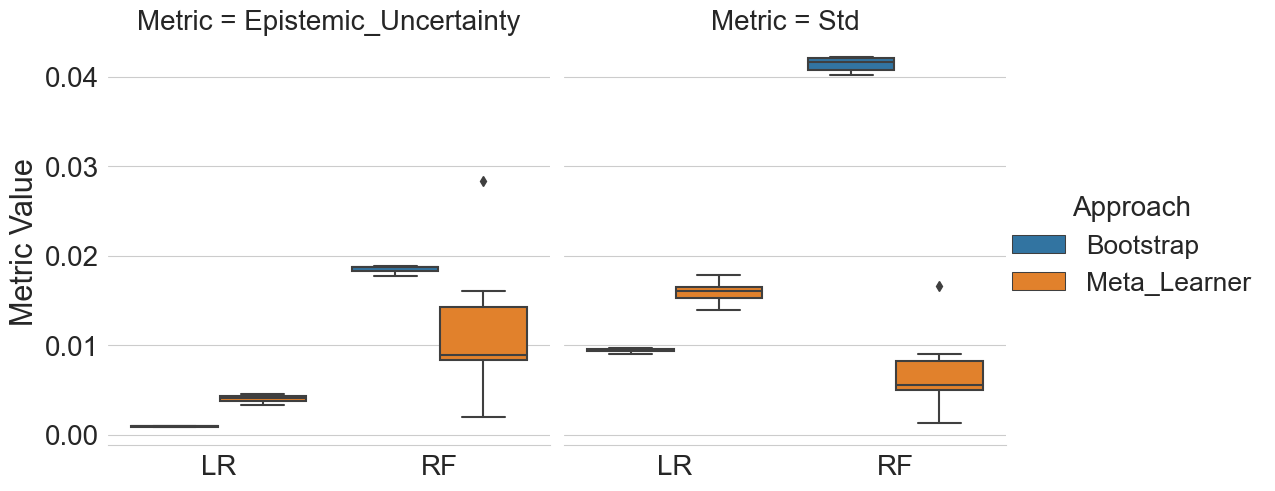

In [15]:
create_plot_for_overall_metrics(all_subgroup_metrics_df,
                                dataset_name=DATASET_NAMES[0],
                                model_names=MODEL_NAMES,
                                metric_names=['Epistemic_Uncertainty', 'Std'],
                                vals_to_replace=vals_to_replace)

### Disparity Metrics

<Figure size 1200x600 with 0 Axes>

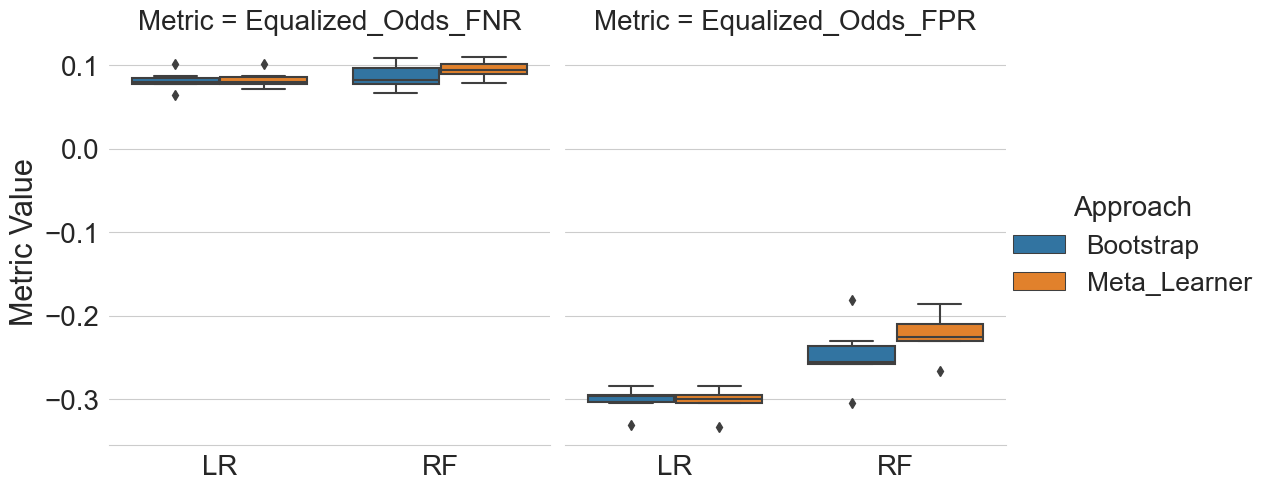

In [16]:
create_plot_for_overall_metrics(all_group_metrics_df,
                                dataset_name=DATASET_NAMES[0],
                                model_names=MODEL_NAMES,
                                group=SENSITIVE_ATTR_FOR_INTERVENTION,
                                metric_names=['Equalized_Odds_FNR', 'Equalized_Odds_FPR'],
                                vals_to_replace=vals_to_replace)

<Figure size 1200x600 with 0 Axes>

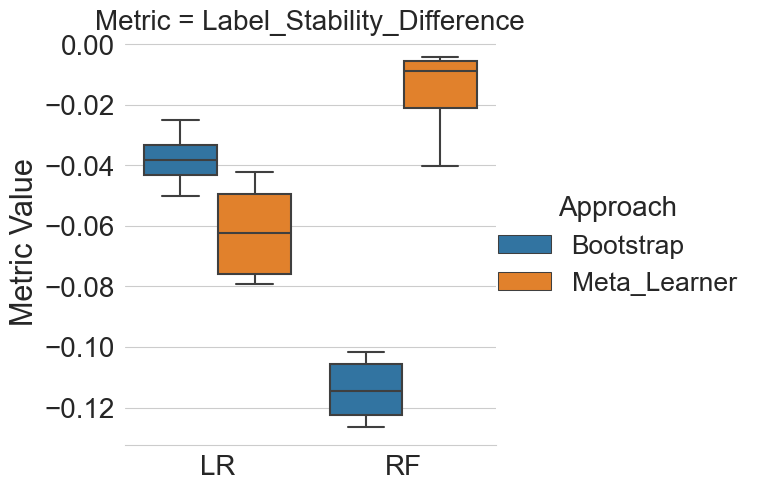

In [17]:
create_plot_for_overall_metrics(all_group_metrics_df,
                                dataset_name=DATASET_NAMES[0],
                                model_names=MODEL_NAMES,
                                group=SENSITIVE_ATTR_FOR_INTERVENTION,
                                metric_names=['Label_Stability_Difference'],
                                vals_to_replace=vals_to_replace)

<Figure size 1200x600 with 0 Axes>

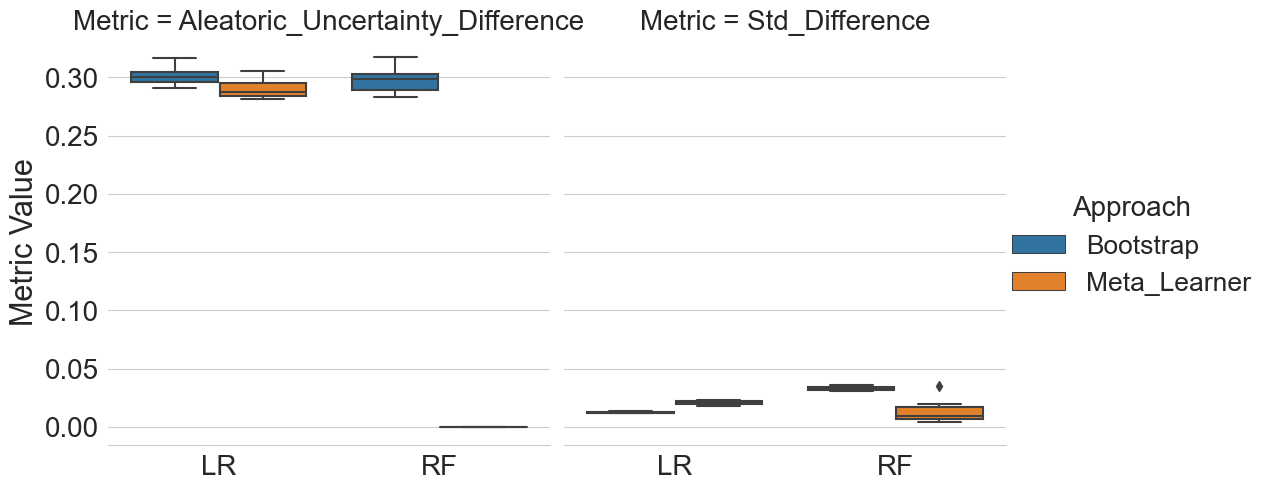

In [18]:
create_plot_for_overall_metrics(all_group_metrics_df,
                                dataset_name=DATASET_NAMES[0],
                                model_names=MODEL_NAMES,
                                group=SENSITIVE_ATTR_FOR_INTERVENTION,
                                metric_names=['Aleatoric_Uncertainty_Difference', 'Std_Difference'],
                                vals_to_replace=vals_to_replace)